# Assignment 2 COMST
Ayse Arslan, Kristian van Kuijk, Carlos Soto Garcia-Delgado, Philip Mühlenfeld, and Ali Alsaeedi

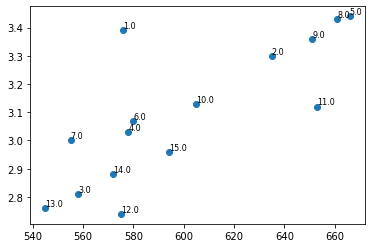

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations_with_replacement
import warnings
warnings.filterwarnings("ignore")

# Load data
law = pd.read_csv('law.csv')

# Add observation column
law['observation'] = range(1, len(law) + 1)

# Plot data
fig, ax = plt.subplots()
ax.scatter(x=law['LSAT'], y=law['GPA'])
for i, row in law.iterrows():
    ax.text(row['LSAT'], row['GPA'], row['observation'], horizontalalignment='left', verticalalignment='bottom', fontsize=8)
plt.show()

#####  The nonparametric bootstrap distribution of the Pearson’s correlation coefficient between LSAT and GPA using B = 40000 bootstrap samples (lab exercise)

Observed correlation coefficient:  0.776374491289407
Bootstrap standard error:  0.13382719109548108
95% Confidence interval: ( 0.45706050635324014 ,  0.961707951247342 )


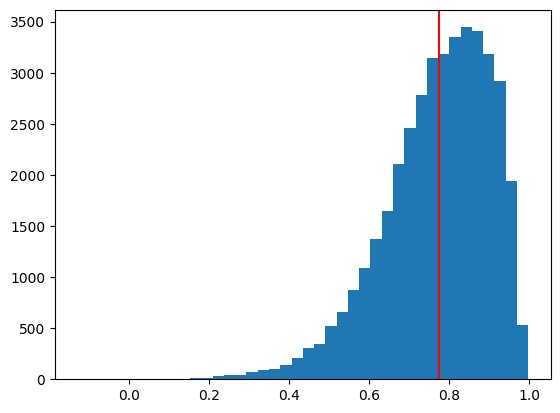

CPU times: user 4.42 s, sys: 21.7 ms, total: 4.44 s
Wall time: 4.35 s


In [2]:
%%time
# Compute the observed correlation coefficient (correlation between LSAT and GPA)
obs_corr = law['LSAT'].corr(law['GPA'])

# Set the number of bootstrap samples
B = 40000

# Create an empty array to store the bootstrap samples
bootstrap_corr = np.zeros(B)

# Generate B bootstrap samples
for i in range(B):
    # Randomly sample/select with replacement from the data
    bootstrap_sample = law.sample(n=len(law), replace=True)
    # Compute the correlation coefficient of the bootstrap sample (like we did in the first lines)
    bootstrap_corr[i] = bootstrap_sample['LSAT'].corr(bootstrap_sample['GPA'])

# Compute the bootstrap standard error and 95% confidence interval (of the array filled with B correlation coefficients)
se_boot = np.std(bootstrap_corr)
lower_ci_boot = np.percentile(bootstrap_corr, 2.5)
upper_ci_boot = np.percentile(bootstrap_corr, 97.5)

# Print the results
print("Observed correlation coefficient: ",obs_corr)
print("Bootstrap standard error: ",se_boot)
print("95% Confidence interval: (", lower_ci_boot, ", ", upper_ci_boot,")")

# Plot results
plt.hist(bootstrap_corr, bins=40)
plt.axvline(x=obs_corr, color='r', linewidth=1.5)
plt.show()

## 1) Recompute using the complete enumaration bootstrap

We will use a subset of the data since 15 data points means 77558760 samples, which is computationally too expensive. Therefore, we only use the first 12 data points.

In [13]:
# Take subset of data
new_law = law[:12]

Number of samples:  1352078
Number of correlation coefficients:  1352078
After removing NaNs:  1352066
Observed correlation coefficient:  0.7242016279655432
Bootstrap standard error:  0.23120393328719824
95% Confidence interval: ( 0.13487025536500818 ,  0.9926446391214782 )


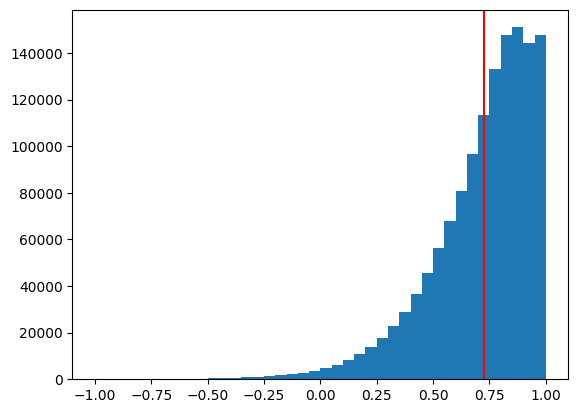

CPU times: user 2min 43s, sys: 45.5 s, total: 3min 29s
Wall time: 3min 56s


In [10]:
%%time

# All possible combinations
combs = combinations_with_replacement(range(len(new_law)), len(new_law))

samples = []
for comb in combs:
    bootstrap_sample = new_law.iloc[list(comb), :]
    samples.append(bootstrap_sample)

print('Number of samples: ', len(samples))

# Compute the Pearson correlation between LSAT and GPA for each bootstrap sample
corrs = [sample['LSAT'].corr(sample['GPA']) for sample in samples]
print('Number of correlation coefficients: ',len(corrs))

obs_corr = new_law['LSAT'].corr(new_law['GPA'])

# Filter out NaN correlation coefficients since it is a smaller dataset and there may 
# have been fewer valid pairs of LSAT and GPA scores that could be used to calculate 
# the correlation coefficient, resulting in more NaN values
corrs = [corr for corr in corrs if not np.isnan(corr)]
print('After removing NaNs: ', len(corrs))

# Same code
se_boot = np.std(corrs)
lower_ci_boot = np.percentile(corrs, 2.5)
upper_ci_boot = np.percentile(corrs, 97.5)

print("Observed correlation coefficient: ",obs_corr)
print("Bootstrap standard error: ",se_boot)
print("95% Confidence interval: (",lower_ci_boot,", ", upper_ci_boot,")")

import matplotlib.pyplot as plt
plt.hist(corrs, bins=40)
plt.axvline(x=obs_corr, color='r', linewidth=1.5)
plt.show()

Standard error increased because the dataset is of size 12 now and not 15. There is more variation in the resulting correlation coefficients as it provides less info. Also with the subset of the data, the analysis can have more outliers. 

For more see report.

## 2) Use Gray codes for compositions to speedup computations

#### Compute gray codes

In [7]:
%%time
# Converts Gray codes to indices 
def get_sample(gray_c):
        samp = []
        for i in range(len(gray_c)):
            #if gray code has a non-zero instance, add it to the sample
            if gray_c[i]>0:
                samp.extend([i]*int(gray_c[i]))
        return samp  
    
# Initialize Gray codes matrix of size m*n where m is the number of combinations and n is the number of data points    
n = len(new_law)
m = np.math.comb((2*n)-1, n-1)
gray_codes = np.zeros((m, n))

# Initialize a temporary list to change indices, ki = 0(since we initialised a zero list)
k = np.zeros(n)

# k[1] = n, t=k[h]=n 
k[0],t = n,n

# h=first i with ki!=0, only non-zero element is k[0]=n
h = 0
# First instance of Gray codes is stored as sequence of indices
gray_codes[0] = get_sample(k)

for i in range(1,m):
    # Stop when k[n]=n
    if k[-1] != n:
        # Set t=k[h],k[h]=0,k[i]=t-1,k[n+1]=k[n+1]+1
        t = k[h]
        k[h] = 0
        k[0] = t - 1
        k[h+1] += 1
        # Update h
        if t != 1:
            h = -1
        h += 1
        # Store the ith instance as sequence of indices
        gray_codes[i] = get_sample(k)

    else:
        break 

CPU times: user 5.86 s, sys: 38.6 ms, total: 5.89 s
Wall time: 5.48 s


#### Compute samples using gray codes

Number of samples:  1352078
Number of correlation coefficients:  1352078
After removing NaNs:  1352066
Observed correlation coefficient:  0.7242016279655432
Bootstrap standard error:  0.23120393328719824
95% Confidence interval: ( 0.13487025536500818 ,  0.9926446391214782 )


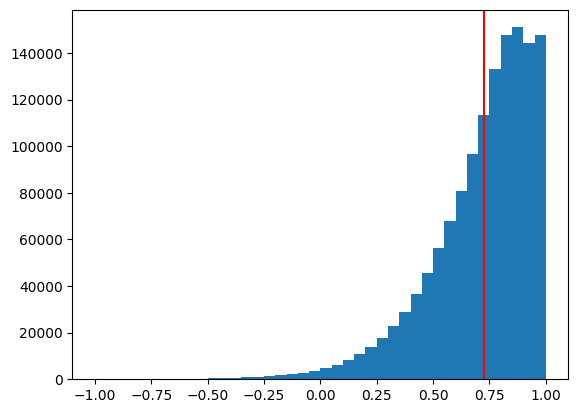

CPU times: user 1min 12s, sys: 3.29 s, total: 1min 16s
Wall time: 1min 22s


In [11]:
%%time

# Compute the samples
samples_gray = new_law.values[gray_codes.astype(int).flatten()].reshape(gray_codes.shape[0], -1)
df_list = []
for row in samples_gray:
    df_list.append(pd.DataFrame(row.reshape(-1, len(new_law.columns)), columns=new_law.columns))
    
print('Number of samples: ', len(df_list))
    
# Compute the Pearson correlation between LSAT and GPA for each bootstrap sample
corrs = [sample['LSAT'].corr(sample['GPA']) for sample in samples]
print('Number of correlation coefficients: ', len(corrs))

obs_corr = new_law['LSAT'].corr(new_law['GPA'])

# Filter out NaN correlation coefficients since it is a smaller dataset and there may 
# have been fewer valid pairs of LSAT and GPA scores that could be used to calculate 
# the correlation coefficient, resulting in more NaN values
corrs = [corr for corr in corrs if not np.isnan(corr)]
print('After removing NaNs: ', len(corrs))

# Same code
se_boot = np.std(corrs)
lower_ci_boot = np.percentile(corrs, 2.5)
upper_ci_boot = np.percentile(corrs, 97.5)

print("Observed correlation coefficient: ",obs_corr)
print("Bootstrap standard error: ",se_boot)
print("95% Confidence interval: (",lower_ci_boot,", ", upper_ci_boot,")")

import matplotlib.pyplot as plt
plt.hist(corrs, bins=40)
plt.axvline(x=obs_corr, color='r', linewidth=1.5)
plt.show()

We can see that the two graphs generated are equivalent, however, using gray codes helped in making the computations faster.

For more see report.

## 3)  How much speedup can you get by using Gray codes? Show either experimentally or theoretically.

See report.

## 4) Which observation(s) do you need to remove from the sample to make the Monte Carlo and complete enumeration bootstrap look more similar?

From the first plot in this notebook we can see that observation 1 and 11 are outliers. Therefore, one can assume that removing these will make both methods look more similar (more about it in the report). Below we also implemented Cook's distance to see which observations are influential.

#### Cook's distance

Whole dataset

In [9]:
import statsmodels.api as sm

# linear regression
X = sm.add_constant(law['LSAT'])
model = sm.OLS(law['GPA'], X).fit()

# Cook's distance
influence = model.get_influence()
cd = influence.cooks_distance[0]

threshold = 4/len(law)
outliers = law[cd > threshold]
outliers

,LSAT,GPA,observation
0,576,3.39,1


Sub-dataset

In [19]:
import statsmodels.api as sm

# linear regression
X = sm.add_constant(new_law['LSAT'])
model = sm.OLS(new_law['GPA'], X).fit()

# Cook's distance
influence = model.get_influence()
cd = influence.cooks_distance[0]

threshold = 4/len(new_law)
outliers = new_law[cd > threshold]
outliers

,LSAT,GPA,observation
0,576,3.39,1


Cook's distance also indicates that the first observation should be removed. When playing around with the threshold, the 'next' observation that is being suggested to be removed it the 11th one. So, same to the intuitive assumption above. Therefore, the answer to this question is observation 1 should be removed for sure, and observation 11 most likely as well.

For more see report.

## 5) Explain why you obtain difference results for Monte Carlo and complete enumeration bootstrap.

First, we re-run the complete enumeration with removing the first observation.

Observed correlation coefficient:  0.8667109723649642
Bootstrap standard error:  0.12192019232871101
95% Confidence interval: ( 0.5850194346698163 ,  0.9973728965612004 )


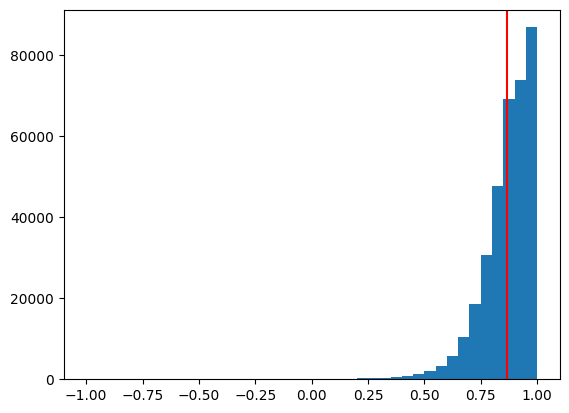

CPU times: user 44.2 s, sys: 11.3 s, total: 55.5 s
Wall time: 1min


In [20]:
%%time

law_ex5 = law[:12].drop([0], axis=0)

# All possible combinations
combs = combinations_with_replacement(range(len(law_ex5)), len(law_ex5))

samples = []
for comb in combs:
    bootstrap_sample = law_ex5.iloc[list(comb), :]
    samples.append(bootstrap_sample)

# Compute the Pearson correlation between LSAT and GPA for each bootstrap sample
corrs = [sample['LSAT'].corr(sample['GPA']) for sample in samples]

obs_corr = law_ex5['LSAT'].corr(law_ex5['GPA'])

# Filter out NaN correlation coefficients since it is a smaller dataset and there may 
# have been fewer valid pairs of LSAT and GPA scores that could be used to calculate 
# the correlation coefficient, resulting in more NaN values
corrs = [corr for corr in corrs if not np.isnan(corr)]

# Same code
se_boot = np.std(corrs)
lower_ci_boot = np.percentile(corrs, 2.5)
upper_ci_boot = np.percentile(corrs, 97.5)

print("Observed correlation coefficient: ",obs_corr)
print("Bootstrap standard error: ",se_boot)
print("95% Confidence interval: (",lower_ci_boot,", ", upper_ci_boot,")")

import matplotlib.pyplot as plt
plt.hist(corrs, bins=40)
plt.axvline(x=obs_corr, color='r', linewidth=1.5)
plt.show()

You can see that the correlation coefficient increased and the plot became a tiny bit smoother. Also, the overall distribution moved a bit to the right (due to higher correlation). Below you can find the Monte Carlo Simulation.

Sample correlation coefficient: 0.8667109723649642
Standard error: 0.07643018237726035
95% confidence interval: (0.7188209894326101, 1.0184217990151265)


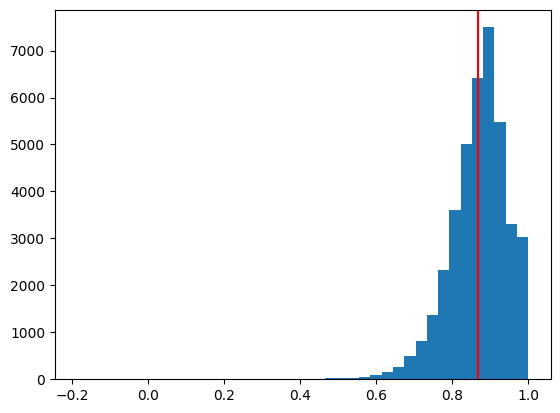

CPU times: user 11.6 s, sys: 106 ms, total: 11.7 s
Wall time: 11.6 s


In [22]:
%%time
import pandas as pd
import numpy as np
import scipy.stats as stats

# Same dataset used as in the complete enumeration bootstrap
law_ex5 = law[:12].drop([0], axis=0)

# Monte Carlo bootstrap
r_obs = np.corrcoef(law_ex5['LSAT'], law_ex5['GPA'])[0, 1]
B = 40000

r_mc = []
for i in range(B):
    idx = np.random.choice(law_ex5.index, size=len(law_ex5), replace=True)
    r = np.corrcoef(law_ex5.loc[idx, 'LSAT'], law_ex5.loc[idx, 'GPA'])[0, 1]
    r_mc.append(r)

se_mc = np.std(r_mc, ddof=1)
ci_mc = stats.norm.interval(0.95, loc=np.mean(r_mc), scale=se_mc)

print('Sample correlation coefficient:', r_obs)
print('Standard error:', se_mc)
print('95% confidence interval:', ci_mc)

import matplotlib.pyplot as plt
plt.hist(r_mc, bins=40)
plt.axvline(x=r_obs, color='r', linewidth=1.5)
plt.show()

For more see report.